In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.regression.linear_model import OLS
from datetime import datetime as dt
from typing import \
    List, \
    Dict, \
    Callable
import math
from scipy.stats import norm


In [2]:
article_nbr = 2
symbol = 'CL'

final_df = pd.read_csv('../data/{}.csv'.format(symbol), 
                 index_col=0, 
                 header=0,
                 parse_dates=[0],
                 date_format='%Y-%m-%d')


# Vol Normalized Returns and Features

In [3]:
# our signals are based on the close
# calculate the vol, inclusing a short vol and a long vol floor
final_df['close_log_ret'] = np.log(final_df['CLOSE']) - np.log(final_df['CLOSE'].shift(1))
final_df['close_log_ret_sqr'] = final_df['close_log_ret'].pow(2)
final_df['close_log_ret_sqr_short'] = final_df['close_log_ret_sqr'].ewm(span=42, min_periods=42).mean()
final_df['close_vol_short'] = final_df['close_log_ret_sqr_short'].pow(0.5)
# final_df['close_log_ret_sqr_long'] = final_df['close_log_ret_sqr'].ewm(span=504, min_periods=42).mean()
# final_df['close_vol_long'] = final_df['close_log_ret_sqr_long'].pow(0.5)
# final_df['close_vol_long_floor'] = 0.5 * final_df['close_vol_long']
# final_df['close_vol'] = final_df[['close_vol_short', 'close_vol_long_floor']].max(axis=1)
final_df['close_vol'] = final_df['close_vol_short']
final_df['close_ret_sr'] = final_df['close_log_ret'] / final_df['close_vol']


# EWMAC_32_128_NVOL
final_df['close_log_ret_sr_cumsum'] = final_df['close_ret_sr'].cumsum()
final_df['close_lsr_ewma_32'] = final_df['close_log_ret_sr_cumsum'].ewm(span=32, min_periods=32).mean()
final_df['close_lsr_ewma_128'] = final_df['close_log_ret_sr_cumsum'].ewm(span=128, min_periods=128).mean()
# final_df['close_lsr_ewmac_32_128_pct'] = (final_df['close_lsr_ewma_32'] - final_df['close_lsr_ewma_128']) \
#         / ((final_df['close_lsr_ewma_32'].abs() + final_df['close_lsr_ewma_128'].abs()) / 2)
final_df['close_lsr_ewmac_32_128'] = (final_df['close_lsr_ewma_32'] - final_df['close_lsr_ewma_128'])


# forward return is open to open
final_df['open_log_ret'] = np.log(final_df['OPEN']) - np.log(final_df['OPEN'].shift(1))
final_df['1df_open_log_ret'] = final_df['open_log_ret'].shift(-2)
final_df['1df_open_log_sr'] = (0.2 / math.sqrt(252)) * final_df['1df_open_log_ret'] / final_df['close_vol']



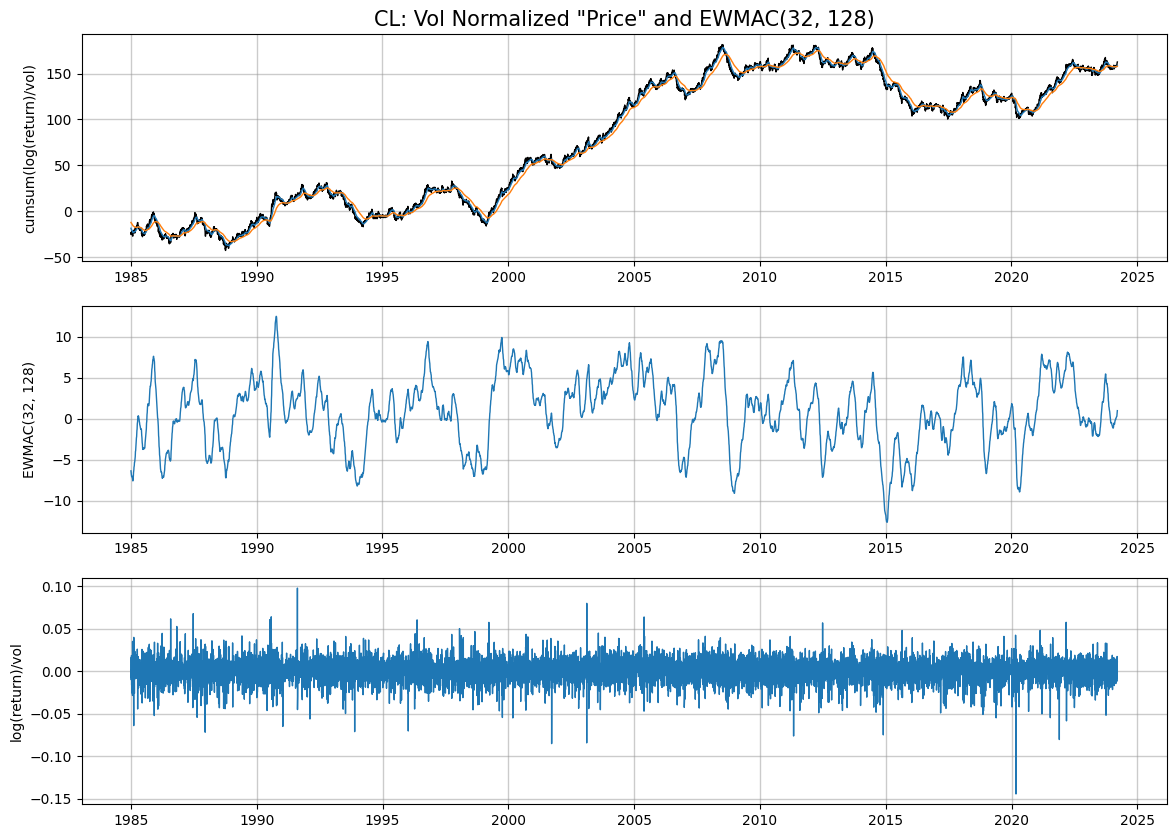

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(14, 10))
ax1.set_title( '{}: Vol Normalized "Price" and EWMAC(32, 128)'.format(symbol), fontsize=15)

ax1.plot(final_df['close_log_ret_sr_cumsum']['1985':], color='black', linewidth='1')
ax1.set_ylabel('cumsum(log(return)/vol)')
ax1.plot(final_df['close_lsr_ewma_32']['1985':], linewidth='1')
ax1.plot(final_df['close_lsr_ewma_128']['1985':], linewidth='1')
ax1.grid(which='major', axis='both', linewidth='1', color='#999999', alpha=0.5)

# ax21 = ax2.twinx()
ln1 = ax2.plot(final_df['close_lsr_ewmac_32_128']['1985':], linewidth='1', label='close_lsr_ewmac_32_128')
# ax21.plot(final_df['close_vol']['1985':], color='red', linewidth='1')
# ln2 = ax21.plot(final_df['close_ewmac_32_128_nvol']['1985':], color='orange', linewidth='1', label='close_ewmac_32_128_nvol')
# ln2 = ax21.plot(final_df['close_lsr_ewmac_32_128_pct']['1985':], color='orange', linewidth='1', label='close_lsr_ewmac_32_128_pct')
# ax2.plot(final_df['close_ewma_32']['1985':], linewidth='1')
# ax2.plot(final_df['close_ewma_128']['1985':], linewidth='1')
ax2.set_ylabel('EWMAC(32, 128)')
ax2.grid(which='major', axis='both', linewidth='1', color='#999999', alpha=0.5)

ax3.plot(final_df['1df_open_log_sr']['1985':], linewidth='1', label='1df_open_log_sr')
ax3.set_ylabel('log(return)/vol')
ax3.grid(which='major', axis='both', linewidth='1', color='#999999', alpha=0.5)

# lines = ln1 + ln2
# labels = [l.get_label() for l in lines]
# ax2.legend(lines, labels, loc=0)

plt.savefig('../output/{}_{}_normalized_price_signal_returns.png'.format(symbol, article_nbr))
plt.show()
plt.close(fig)


## Idicator vs Log Returns

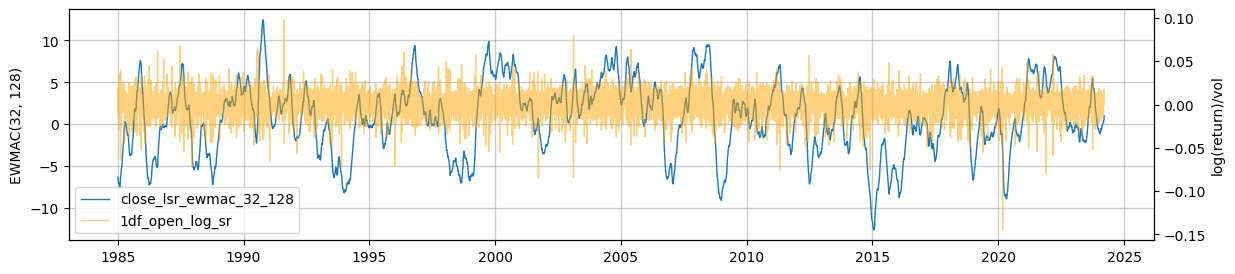

In [5]:
fig, ax1 = plt.subplots(1, figsize=(14, 3))
# plt.set_title( '{}: Vol Normalized "Price" and EWMAC(32, 128)'.format(symbol), fontsize=15)

ln1 = ax1.plot(final_df['close_lsr_ewmac_32_128']['1985':], linewidth='1', label='close_lsr_ewmac_32_128')
ax1.set_ylabel('EWMAC(32, 128)')
ax1.grid(which='major', axis='both', linewidth='1', color='#999999', alpha=0.5)

ax11 = ax1.twinx()
ln2 = ax11.plot(final_df['1df_open_log_sr']['1985':], color='orange', alpha=0.5, linewidth='1', label='1df_open_log_sr')
ax11.set_ylabel('log(return)/vol')
# ax11.grid(which='major', axis='both', linewidth='1', color='#999999', alpha=0.5)

lines = ln1 + ln2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc=0)

plt.savefig('../output/{}_{}_signal_1db_returns.png'.format(symbol, article_nbr))
plt.show()
plt.close(fig)


## Indicator vs Mean 128 Day Log Returns

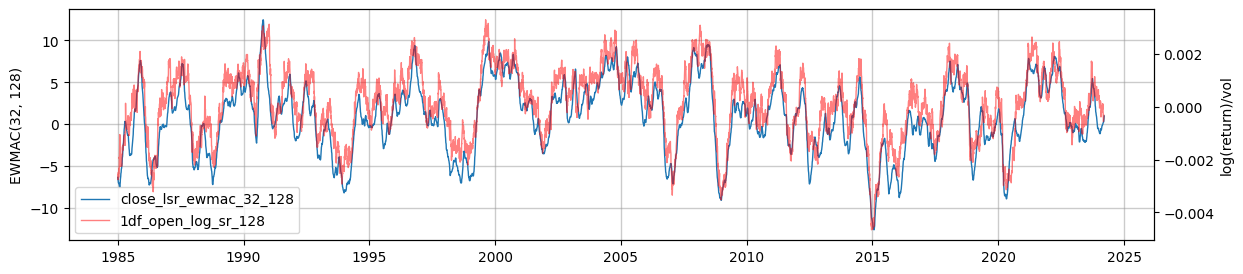

In [6]:
days_forward = 128

# calculate smoothed 128 day returns (backward looking)
final_df['1df_open_log_sr_128'] = final_df['1df_open_log_sr'].rolling(window=days_forward).mean()


fig, ax1 = plt.subplots(1, figsize=(14, 3))
# plt.set_title( '{}: Vol Normalized "Price" and EWMAC(32, 128)'.format(symbol), fontsize=15)

ln1 = ax1.plot(final_df['close_lsr_ewmac_32_128']['1985':], linewidth='1', label='close_lsr_ewmac_32_128')
ax1.set_ylabel('EWMAC(32, 128)')
ax1.grid(which='major', axis='both', linewidth='1', color='#999999', alpha=0.5)

ax11 = ax1.twinx()
ln2 = ax11.plot(final_df['1df_open_log_sr_128']['1985':], color='red', alpha=0.5, linewidth='1', label='1df_open_log_sr_128')
ax11.set_ylabel('log(return)/vol')
# ax11.grid(which='major', axis='both', linewidth='1', color='#999999', alpha=0.5)

lines = ln1 + ln2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc=0)

plt.savefig('../output/{}_{}_signal_128db_returns.png'.format(symbol, article_nbr))
plt.show()
plt.close(fig)


## Indicator vs Mean 128 Day Forward Open-to-Open Log Return Vol Normalized

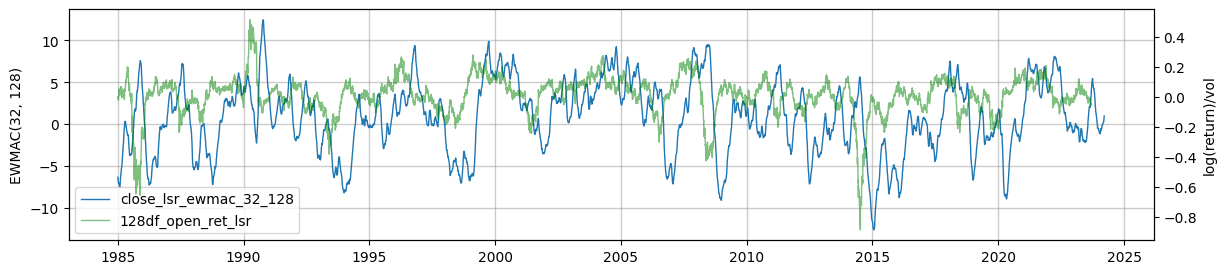

In [8]:
# calculate forwards 128 dayreturns
final_df['128df_open_log_ret'] = final_df['1df_open_log_ret'].rolling(window=days_forward).mean().shift(-days_forward)
final_df['128df_open_ret_lsr'] = final_df['128df_open_log_ret'] / final_df['close_vol']
final_df['128_close_log_ret'] = (np.log(final_df['CLOSE']) - np.log(final_df['CLOSE'].shift(days_forward))) / days_forward
final_df['128df_close_ret_log'] = final_df['128_close_log_ret'].shift(-days_forward)
final_df['128df_close_ret_lsr'] = final_df['128df_close_ret_log'] / final_df['close_vol']


fig, ax1 = plt.subplots(1, figsize=(14, 3))
# plt.set_title( '{}: Vol Normalized "Price" and EWMAC(32, 128)'.format(symbol), fontsize=15)

ln1 = ax1.plot(final_df['close_lsr_ewmac_32_128']['1985':], linewidth='1', label='close_lsr_ewmac_32_128')
ax1.set_ylabel('EWMAC(32, 128)')
ax1.grid(which='major', axis='both', linewidth='1', color='#999999', alpha=0.5)

ax11 = ax1.twinx()
ln2 = ax11.plot(final_df['128df_open_ret_lsr']['1985':], color='green', alpha=0.5, linewidth='1', label='128df_open_ret_lsr')
# ln2 = ax11.plot(final_df['close_128df_ret_lsr']['1985':], color='orange', alpha=0.5, linewidth='1', label='open_128df_ret_lsr')
ax11.set_ylabel('log(return)/vol')

lines = ln1 + ln2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc=0)

plt.savefig('../output/{}_{}_signal_128df_returns.png'.format(symbol, article_nbr))
plt.show()
plt.close(fig)
